# Init

In [63]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

import collections

%matplotlib inline


carImages = glob.glob('dataset/vehicles/vehicles/**/*.png')
nonCarImages = glob.glob('dataset/non-vehicles/non-vehicles/**/*.png')

testImages = glob.glob('test_images/test*.jpg')

print("carImages: %s" % len(carImages))
print("nonCarImages: %s" % len(nonCarImages))

print("testimages: %s" % len(testImages))

carImages: 8792
nonCarImages: 8968
testimages: 6


# HOG

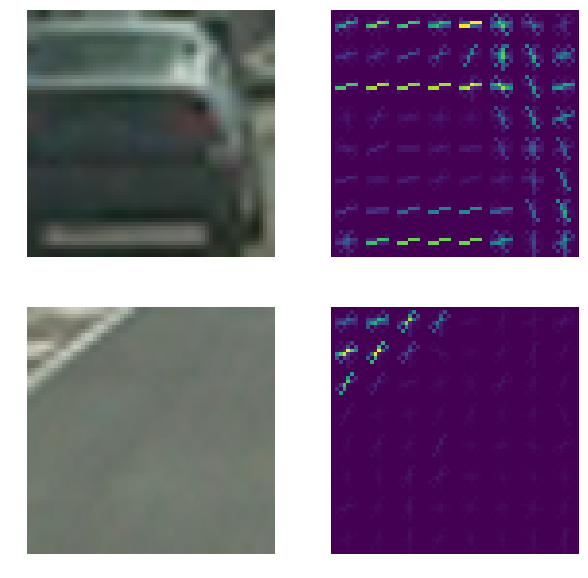

In [3]:
def get_hog_features(img, ori, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=ori, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=ori, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
carImg = mpimg.imread(carImages[1])
grayCar = cv2.cvtColor(carImg, cv2.COLOR_RGB2GRAY)
carFeatures, carHog = get_hog_features(grayCar, 9, 8, 2, vis=True, feature_vec=False)

nonCarImg = mpimg.imread(nonCarImages[3])
grayNonCar = cv2.cvtColor(nonCarImg, cv2.COLOR_RGB2GRAY)
nonCarFeatures, nonCarHog = get_hog_features(grayNonCar, 9, 8, 2, vis=True, feature_vec=False)

# Visualize 
f, axis = plt.subplots(2, 2, figsize=(10,10))
axis = axis.ravel()
#f.subplots_adjust(hspace = 0.4, wspace = 0.2)
axis[0].imshow(carImg)
axis[0].axis('off')
axis[1].imshow(carHog)
axis[1].axis('off')
axis[2].imshow(nonCarImg)
axis[2].axis('off')
axis[3].imshow(nonCarHog)
axis[3].axis('off')

plt.savefig('./output_images/HOG.png')

# Feature Extraction

In [4]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 12 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

carFeatures = extract_features(carImages, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
nonCarFeatures = extract_features(nonCarImages, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Done Extracting Features ...")


Done Extracting Features ...


# Classifier

In [5]:

# Create an array stack of feature vectors
X = np.vstack((carFeatures, nonCarFeatures)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(carFeatures)), np.zeros(len(nonCarFeatures))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 10 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 5088
9.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


# Sliding Window

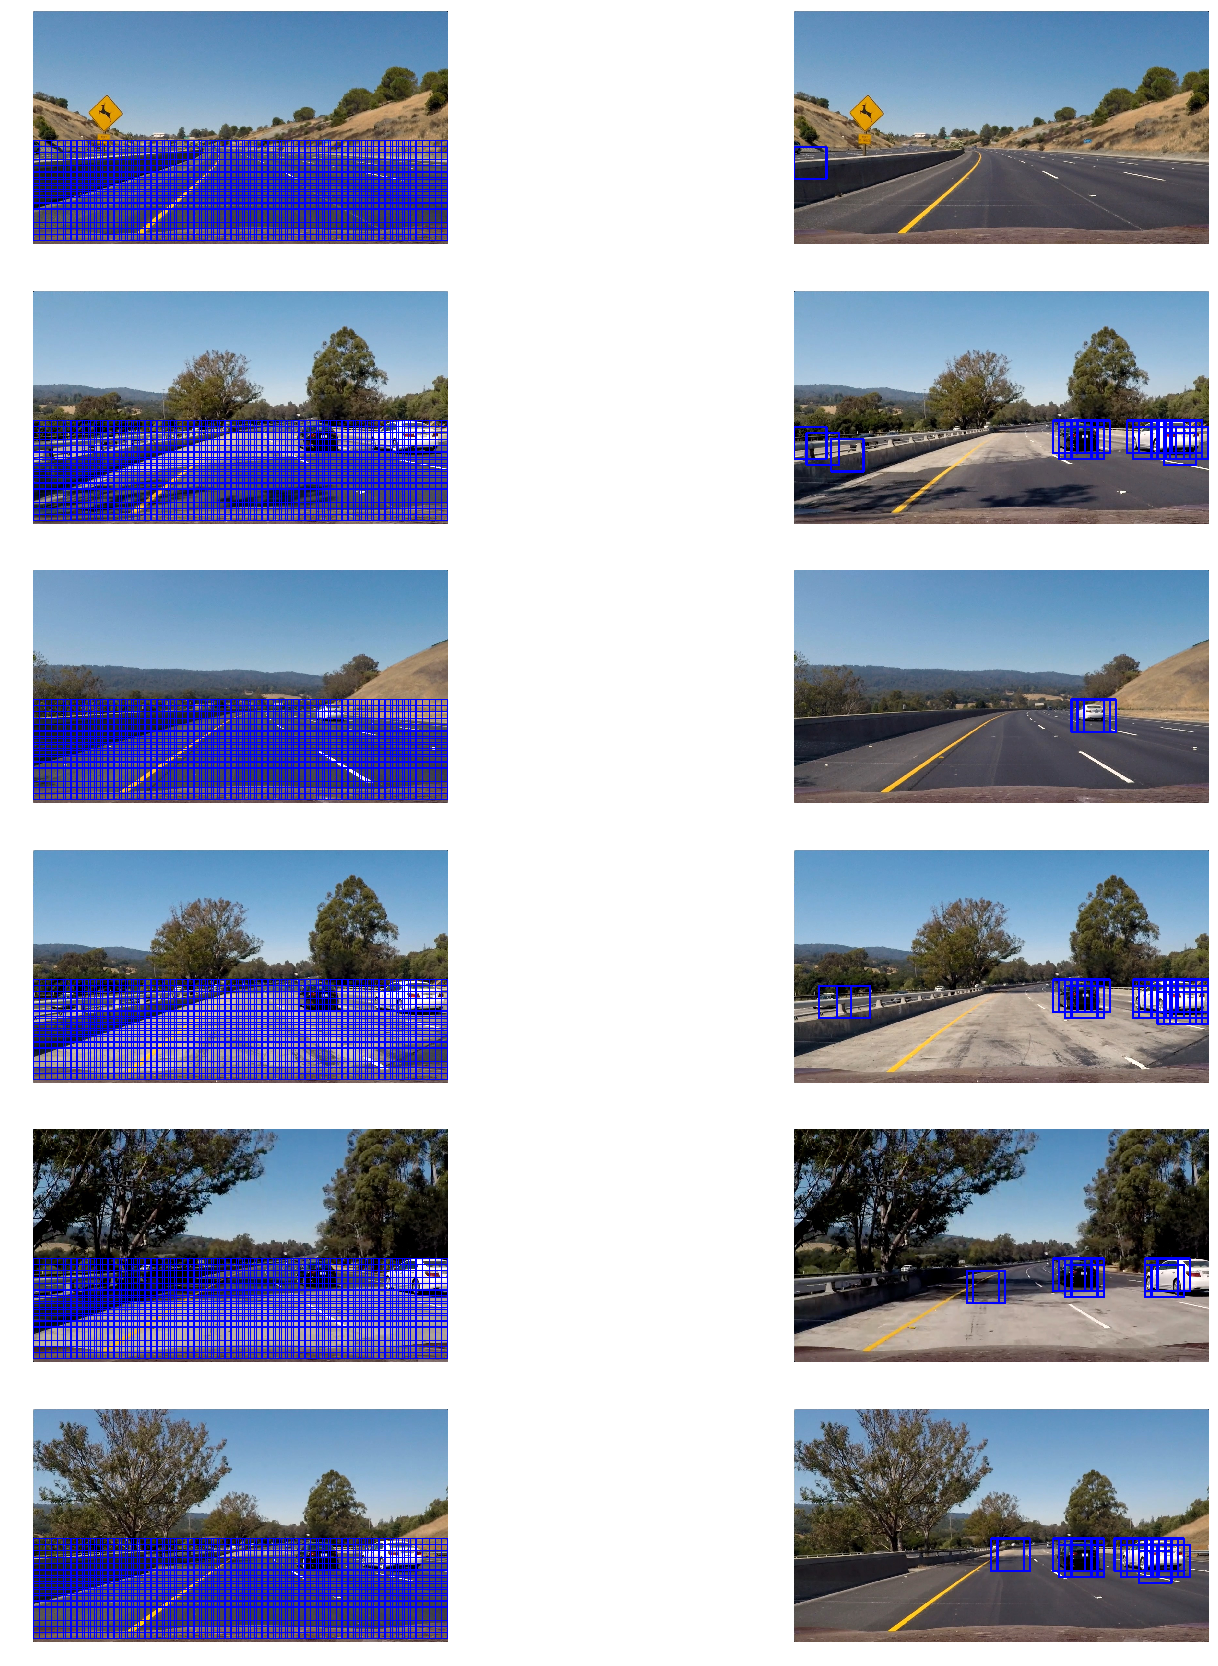

In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=8):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


    
    
f, axis = plt.subplots(int(len(testImages)), 2, figsize=(25,30) )
axis = axis.ravel()
c = 0
# Apply sliding window search
for path in testImages:
    img = mpimg.imread(path)
    copy1 = np.copy(img)
    copy2 = np.copy(img)
    #normalize
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(100, 100), xy_overlap=(0.80, 0.80))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    wimg1 = draw_boxes(copy1, windows, color=(0, 0, 255), thick=2)
    wimg2 = draw_boxes(copy2, hot_windows, color=(0, 0, 255), thick=6)
    
    
    axis[c].imshow(wimg1)
    axis[c].axis('off')
    axis[c+1].imshow(wimg2)
    axis[c+1].axis('off')
    c += 2

plt.savefig('./output_images/slide_window.png')



# Hog SubWindows

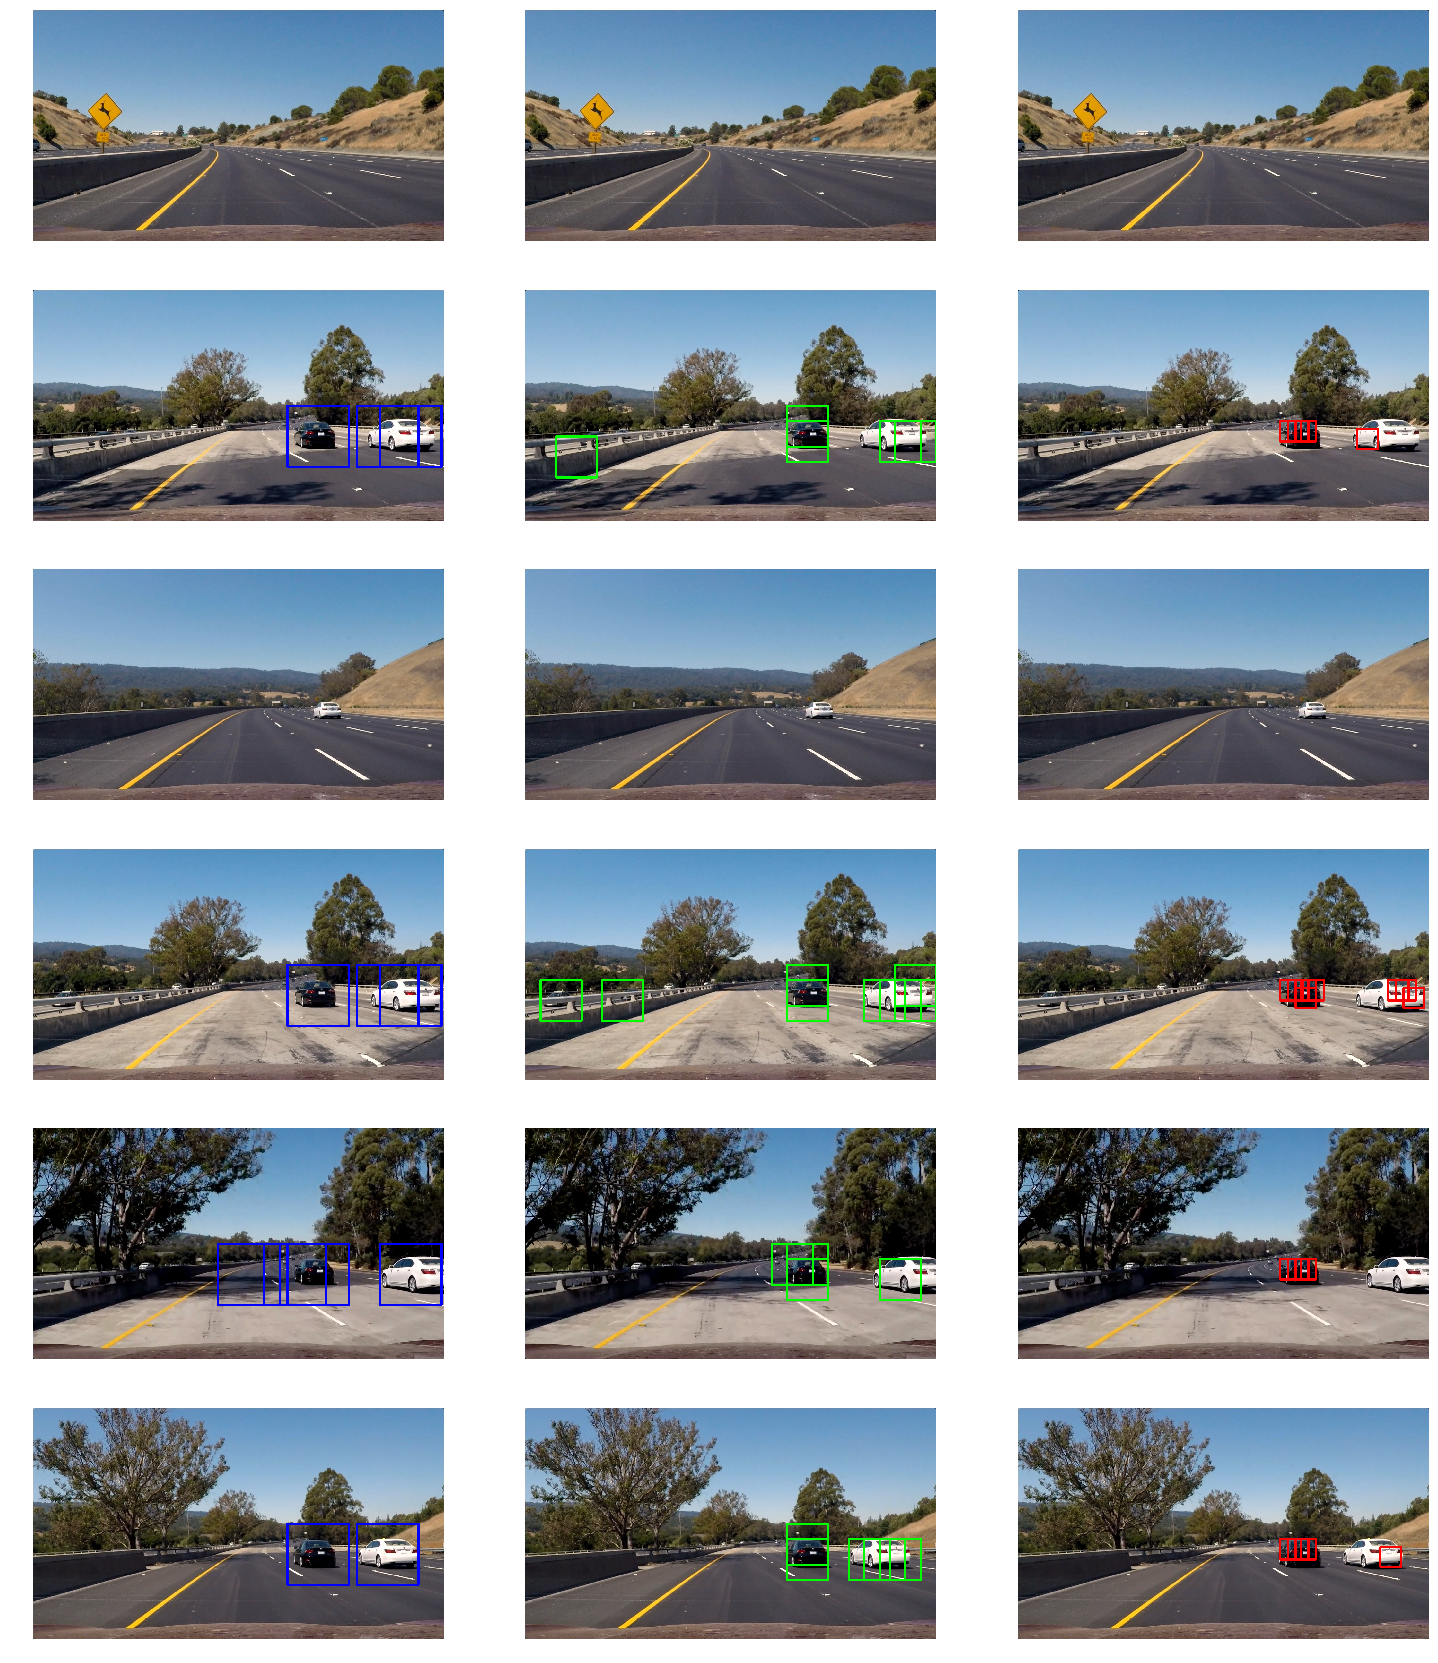

In [46]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boundingbox = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boundingbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boundingbox





boxList = []
f, axis = plt.subplots(int(len(testImages)), 3, figsize=(25,30) )
axis = axis.ravel()
c = 0
for path in testImages:
    img = mpimg.imread(path)
    copy = np.copy(img)
    size = (img.shape[1], img.shape[0])
    
    ## biggest windows for 80% height to 95%
    #ystart = int(size[1]*0.6 - size[1]*0.6 % 32)
    #ystop = int(size[1] - size[1] % 32)
    #print("%s, %s" % (ystart, ystop))
    ystart = int(size[1]/2)
    ystop = int(size[1])
    scale = 3.0
    boxes1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    wimg1 = draw_boxes(copy, boxes1, color=(0, 0, 255), thick=6)

    # middle windows for 55% height to 85%
    #ystart = int(size[1]*0.55 - size[1]*0.55 % 24)
    #ystop = int(size[1]*0.85  + size[1]*0.85 % 24)
    ystart = int(size[1]/2)
    ystop = int(size[1])
    #print("%s, %s" % (ystart, ystop))
    scale = 2.0
    boxes2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    wimg2 = draw_boxes(copy, boxes2, color=(0, 255, 0), thick=6)

    #little windows for half height to 70%
    #ystart = int(size[1] * 0.5 - size[1]*0.50 % 16)
    #ystop = int(size[1] * 0.70 + size[1]*0.70 % 16)
    #print("%s, %s" % (ystart, ystop))
    ystart = int(size[1]/2)
    ystop = int(size[1])
    scale = 1.0
    boxes3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    wimg3 = draw_boxes(copy, boxes3, color=(255, 0, 0), thick=6)

    boxList.append( (boxes1 + boxes2 + boxes3) )
        
    axis[c].imshow(wimg1)
    axis[c].axis('off')
    axis[c+1].imshow(wimg2)
    axis[c+1].axis('off')
    axis[c+2].imshow(wimg3)
    axis[c+2].axis('off')
    c += 3
    
    print("")

plt.savefig('./output_images/find_cars.png')


# Heatmap

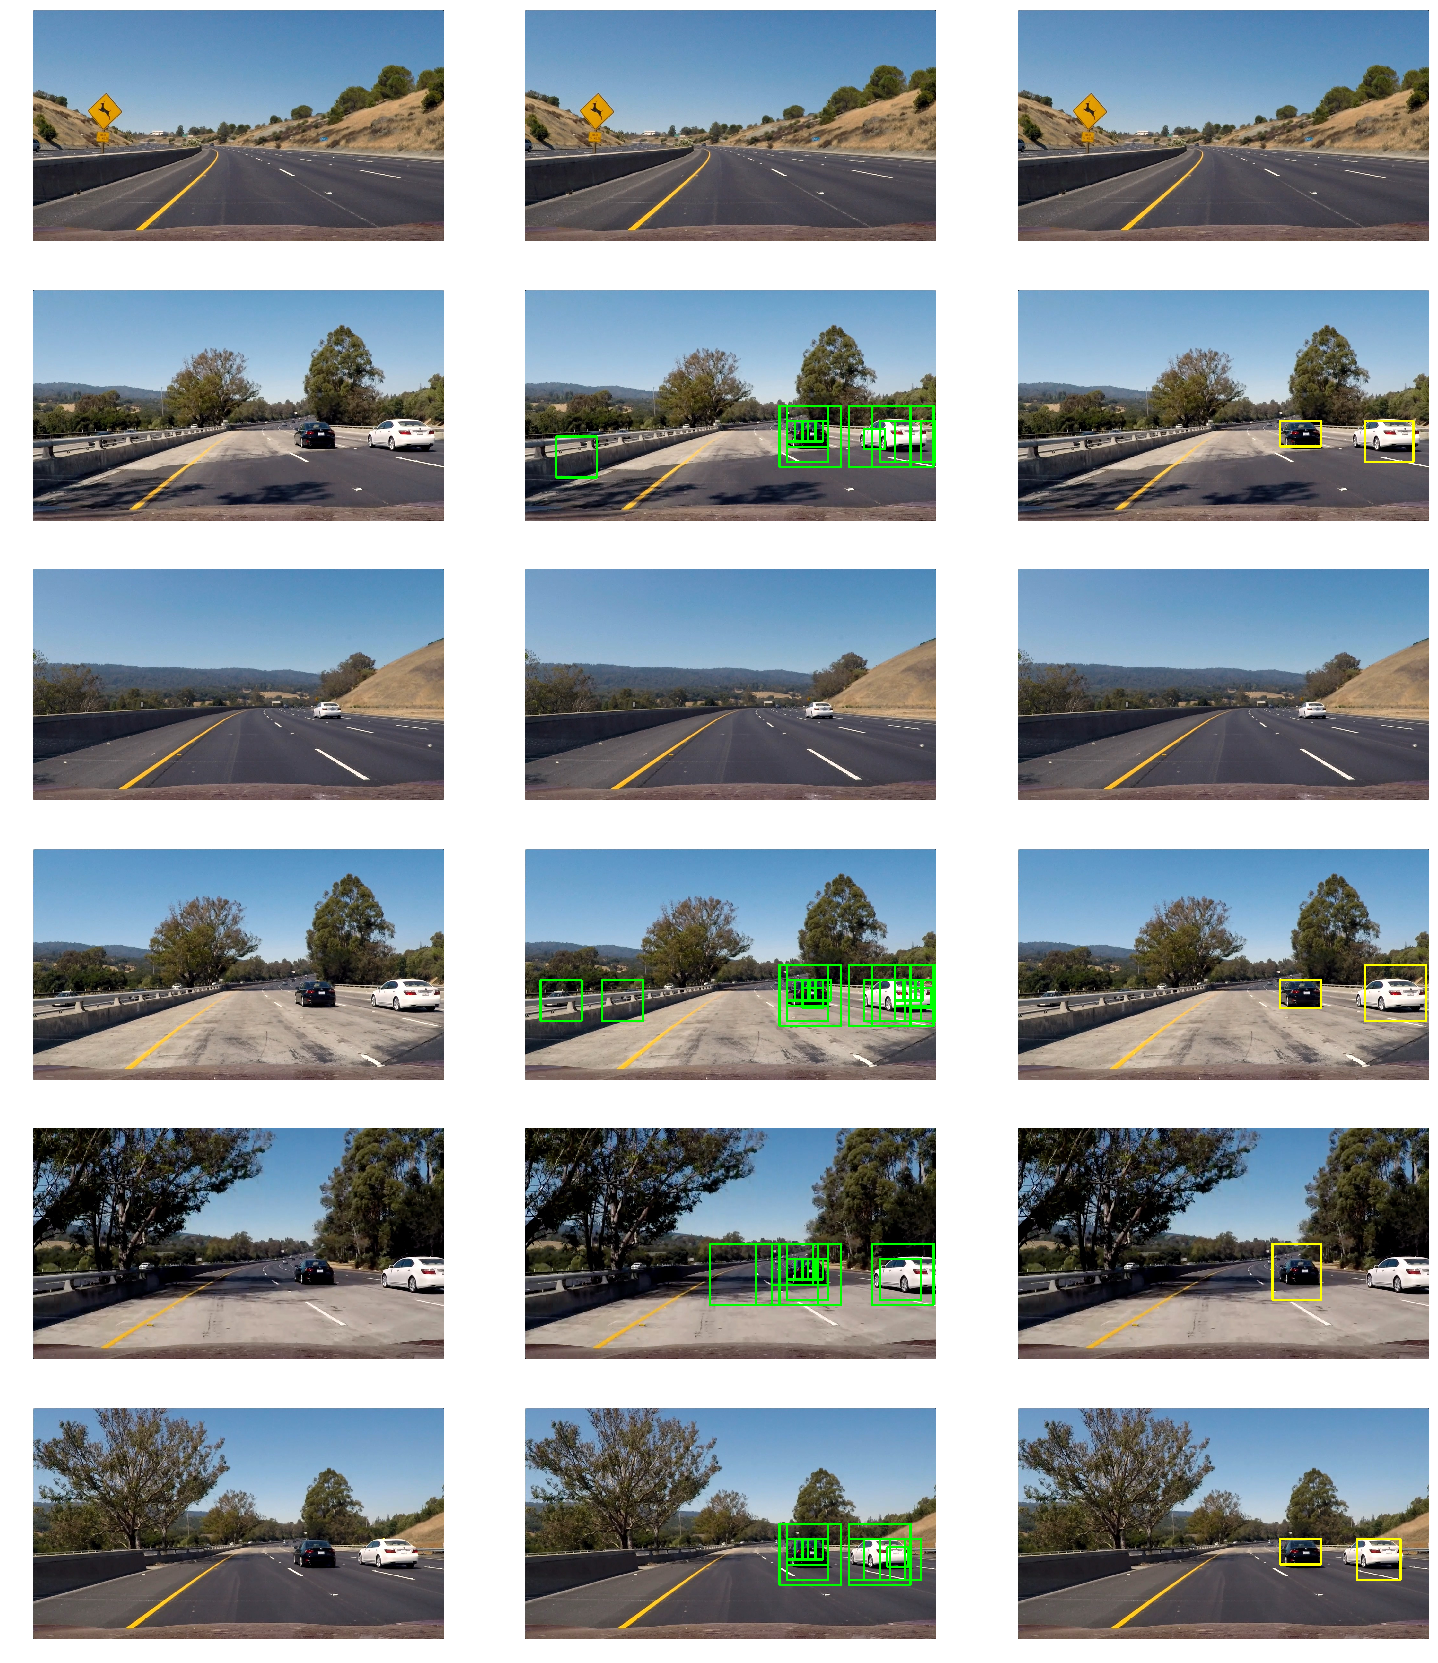

In [50]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, color=(255,255,0), thickness=6):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,255,0), 6)
    # Return the image
    return img






f, axis = plt.subplots(int(len(testImages)), 3, figsize=(25,30) )
axis = axis.ravel()
i = 0
c = 0
for path in testImages:
    img = mpimg.imread(path)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    #build up heat boxes
    heat = add_heat(heat,boxList[i])

    #threshold boxes to filter noise
    heat = apply_threshold(heat,2)

    #visualize
    heatmap = np.clip(heat, 0, 255)

    #find resulting boxes using labels
    labels = label(heatmap)
    
    #draw everything
    copy = draw_labeled_bboxes(np.copy(img), labels, color=(255,255,0), thickness=10)
    wimg = draw_boxes(np.copy(img), boxList[i], color=(0, 255, 0), thick=6)
    
    axis[c].imshow(img)
    axis[c].axis('off')
    axis[c+1].imshow(wimg)
    axis[c+1].axis('off')
    axis[c+2].imshow(copy)
    axis[c+2].axis('off')
    c += 3
    i += 1

plt.savefig('./output_images/labels.png')
    
    

# Video Pipeline

In [82]:
def processVideo(img):
    
    global boxBuffer
    
    #init
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 10  # HOG orientations
    pix_per_cell = 12 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    size = (img.shape[1], img.shape[0])

    
    #bbs
    ## biggest windows for 80% height to 95%
    #ystart = int(size[1]*0.6 - size[1]*0.6 % 32)
    #ystop = int(size[1] - size[1] % 32)
    #print("%s, %s" % (ystart, ystop))
    ystart = int(size[1]/2)
    ystop = int(size[1])
    scale = 3.0
    bb1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # middle windows for 55% height to 85%
    #ystart = int(size[1]*0.55 - size[1]*0.55 % 24)
    #ystop = int(size[1]*0.85  + size[1]*0.85 % 24)
    #print("%s, %s" % (ystart, ystop))
    ystart = int(size[1]/2)
    ystop = int(size[1])
    scale = 2.0
    bb2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #little windows for half height to 70%
    #ystart = int(size[1] * 0.5 - size[1]*0.50 % 16)
    #ystop = int(size[1] * 0.70 + size[1]*0.70 % 16)
    #print("%s, %s" % (ystart, ystop))
    ystart = int(size[1]/2)
    ystop = int(size[1])
    scale = 1.0
    bb3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    #for b in bb1:
    #    boxBuffer.append(b)
    #for b in bb2:
    #    boxBuffer.append(b)
    #for b in bb3:
    #    boxBuffer.append(b)

    #buffered boxes into heatmap, so that we dont loose the object that fast
    boxes = bb1 + bb2 + bb3
    boxBuffer.append(boxes)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for b in boxBuffer:
        heat = add_heat(heat, b)
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)
    
    #heatmap
    #heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #heat = add_heat(heat,boxes)
    #heat = apply_threshold(heat,2)
    #heatmap = np.clip(heat, 0, 255)

    #labels
    labels = label(heatmap)
    
    #vis
    copy = np.copy(img)
    copy = draw_labeled_bboxes(copy, labels)
    
    #copy = draw_boxes(copy, bb1, color=(255, 0, 0), thick=6)
    #copy = draw_boxes(copy, bb2, color=(0, 255, 0), thick=6)
    #copy = draw_boxes(copy, bb3, color=(0, 0, 255), thick=6)
    #copy = draw_boxes(copy, boxBuffer, color=(0, 255, 0), thick=6)

    
    return copy

In [84]:

boxBuffer = collections.deque(maxlen=20)

project_video_output = "project_video_output.mp4"
project_video_input = VideoFileClip('project_video.mp4')


#normal video
processed_project_video = project_video_input.fl_image(processVideo)
%time processed_project_video.write_videofile(project_video_output, audio=False)


#process clipped 
#clip = project_video_input.subclip(20,25)
#processed_project_video = clip.fl_image(processVideo)
#%time processed_project_video.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [19:41<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 21min 1s, sys: 13.2 s, total: 21min 14s
Wall time: 19min 41s
